# AZ_0251_Saphira Data Processing and Plotting Noteboook

### Converts force data from load cell into drawer closing/opening force, accounting for rig geometry. Plots the force traces, and saves the converted forces as a .csv

### Input data should be in the form of a .csv file containing force and displacement data in alternating columns

### Import modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

### Class defining rig geometry, and functions to calculate force at drawer from force at load cell, and to convert load cell displacement to drawer angle

In [2]:
class Rig:
    # Define constants, rig geometric parameters
    def __init__(self):
        self.bearing_rad = 9.5
        self.pivot_perp_dist = 62.5
        self.moment_arm = 31.66
        self.bearing_dist = 40.5
        self.swingarm_halfdepth = 5.25
        self.claw_angle = 21.2
        
        self.load_offset_up = 0.242
        self.load_offset_down = -0.352
    
    
    # Rig conversion from displacement to drawer angles
    def angle_conversion(self, disp, peak_disp, peak_indices):
        # For downsweep,
        h = peak_disp - disp[:peak_indices]
        w = np.arctan((self.bearing_rad + self.swingarm_halfdepth + h) / self.pivot_perp_dist)
        x = (self.bearing_rad + self.swingarm_halfdepth+h) / np.sin(w)
        y = np.arccos((self.bearing_rad + self.swingarm_halfdepth) / x)
        self.down_angle = w+y - np.pi/2
        self.down_angle_deg = np.rad2deg(self.down_angle)
        
        # For upsweep,
        h = peak_disp - disp[peak_indices:] - (2*(self.bearing_rad+self.swingarm_halfdepth))
        w = np.arctan((h - self.bearing_rad - self.swingarm_halfdepth) / self.pivot_perp_dist)
        x = (h - self.bearing_rad - self.swingarm_halfdepth) / np.sin(w)
        y = np.arcsin((self.bearing_rad + self.swingarm_halfdepth) / x)
        self.up_angle = w+y
        self.up_angle[self.up_angle<0] = 0 # If angle is <0 it is in the dead-range of the sweep between the bearings, so just set the angle to zero
        self.up_angle_deg = np.rad2deg(self.up_angle)
        
        # Re-combine up and down sweeps
        self.angle_deg = np.concatenate((self.down_angle_deg, self.up_angle_deg))
      
        
    # Convert force at load cell to force at drawer
    def force_conversion(self, force):
        down_eff_arm_len = self.pivot_perp_dist + self.bearing_rad*np.sin(self.down_angle)
        up_eff_arm_len = self.pivot_perp_dist - self.bearing_rad*np.sin(self.up_angle)
        eff_arm_len = np.concatenate((down_eff_arm_len, up_eff_arm_len))
        self.force_drawer = eff_arm_len * force * np.cos(np.deg2rad(self.claw_angle)) / self.moment_arm

### main() function

In [3]:
def main():
    # import data from csv
    data = pd.read_csv(fr'{folder}\{file}', header=None, skiprows=range(3))
    
    # Pre-processing
    # Flip data so it's positive when closing, remove useless columns, and concatenate open and close forces and dispalcmentsinto single numpy arrays
    force_data = np.concatenate((-np.array(data)[:, ::8], -np.array(data)[:, 4::8]), axis=0)
    disp_data = np.concatenate((-np.array(data)[:, 1::8], -np.array(data)[:, 5::8]), axis=0)
    
    # place into list of np arrays, and remove NaNs
    # NaN's must be removed column by column!
    force = []
    disp = []
    for i in range(force_data.shape[1]):
        disp.append(disp_data[:,i][np.logical_not(np.isnan(disp_data[:,i]))])
        force.append(force_data[:,i][np.logical_not(np.isnan(force_data[:,i]))])


    # # Initialise lists for indices of bottom out points and cumulative disps
    peak_indices = []
    peak_disp = []
    disp_cumulative = copy.deepcopy(disp)
    
    # Find bottom-out point of test rig, and combine and plot raw force traces from open and close datasets
    # plt.figure()
    for i in range(len(force)):
        # Find index of bottom out point i.e. datapoint of max force when closing. This is the point between the downsweep and upsweep
        peak_indices.append(np.nanargmax(force[i])) 
        
        # Find displacement at bottom out point, and make all the disps after that cumulative, including disp_open
        # i.e. "mirror" all the disps after the bottom out point
        peak_disp.append(disp[i][peak_indices[-1]])
        disp_cumulative[i][peak_indices[-1]:] = disp_cumulative[i][peak_indices[-1]:] + 2*(peak_disp[-1] - disp_cumulative[i][peak_indices[-1]:])
        
        # # Also, adjust for rig friction offsets for up and down sweeps
        force[i][:peak_indices[i]] += rig.load_offset_down
        force[i][peak_indices[i]:] += rig.load_offset_up
        
    
    # Find "pause range", either by finding data range where nothing is happening, or using trig
    # plt.figure()
    pause_end_indices = []
    
    rolling_n = 50
    for i in range(len(disp_cumulative)):
        for j in range(len(disp_cumulative[i][peak_indices[i]:])):
            if not(-0.5<force[i][j]<1) and (0.975*np.mean(disp_cumulative[i][j:j+rolling_n]) < disp_cumulative[i][j] < 1.025*np.mean(disp_cumulative[i][j:j+rolling_n])):
                break
        pause_end_indices.append(j+peak_indices[i])
    
    legend_list = [*range(len(force))]
      
    # Convert force at load cell to force at claw
    # Use raw displacement values for trig calculations (not cumulative!)
    angle_deg = []
    angle_deg_cumulative = []
    eff_arm_len = []
    force_drawer = []
    force_open_max = []
    force_close_max = []
    
    fig, ax = plt.subplots()
    ax = fig.add_axes((0,0,1,1))
    for i in range(len(force)):
        # Calculate corrected forces and drawer angles
        rig.angle_conversion(disp[i], peak_disp[i], peak_indices[i])
        rig.force_conversion(force[i])
        
        # Save corrected forces and drawer angles into a list
        angle_deg.append(rig.angle_deg)
        force_drawer.append(rig.force_drawer)
        
        # Make angles cumulative
        angle_deg_cumulative.append(np.zeros(angle_deg[i].shape[0]))
        angle_deg_cumulative[i][1:] = np.cumsum(np.abs(angle_deg[i][1:] - angle_deg[i][:-1]))
        # cumul = np.abs(angle_deg[i][peak_indices[i]:] - angle_deg[i][peak_indices[i]-1:-1])
        
        # Calculate max closing/opening force, ignoring range when rig bottoms/tops out
        force_close_max.append(np.nanmax(force_drawer[i][:peak_indices[i]-100]))
        force_open_max.append(np.abs(np.nanmin(force_drawer[i][peak_indices[i]+50:-500])))
        
        # plot figures
        ax.plot(angle_deg_cumulative[i], force_drawer[i], linewidth=1)
    
    # Format plot  
    # plt.legend(leg_names, bbox_to_anchor=(1, 0.5), loc='center left', ncol=2)
    ax.set_ylim((-5,30))
    ax.set_xlim((0,70))
    plt.grid(axis='y', linewidth=1, alpha=0.5)
    # ax.legend([1,2], bbox_to_anchor=(0.5, -0.15), loc='center', ncol=2)
    ax.set_title(f'Force-Cumulative Angle of {device}')
    ax.set_xlabel('Cumulative angle (°)')
    ax.set_ylabel('Force at Drawer (N)')
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_linewidth(1)
        
    ax.spines['right'].set_color('white')
    ax.spines['top'].set_alpha(0.1)
    plt.show()
    
    
    # Save corrected forces and cumulative angles as a .csv
    corrected_forces = []
    column_names = []
    for i in range(len(force_drawer)):
        corrected_forces.append(force_drawer[i].tolist())
        corrected_forces.append(angle_deg_cumulative[i].tolist())
        column_names.append('Force')
        column_names.append('Angle (cumulative)')
        
    corrected_forces = pd.DataFrame(corrected_forces).T
    corrected_forces.columns = column_names
    corrected_forces.to_csv(fr'{folder}/{file[:-4]}_Corrected_forces.csv', index=False)
    
    

### RUN this to import and process data plot force traces, and save corrected force/angle data as a .csv
### Input the `folder` directory containing the .csv file, and set the filename of the input .csv file
### .csv outputs will be saved in the same `folder`
### Input the `device` name/number/build standard used in the test; it will also show up in the plot titles

Input .csv data folder directory: S:\Projects\AZ\0251_Capsule Inhaler Concepts\Documents\Verification & Test\Rapid testing\2022.03.02-HF study springs\Returned_Devices\220401\Plotting
Input .csv data filename (include ".csv"):220401_Devices_plotting.csv
Device name: device 


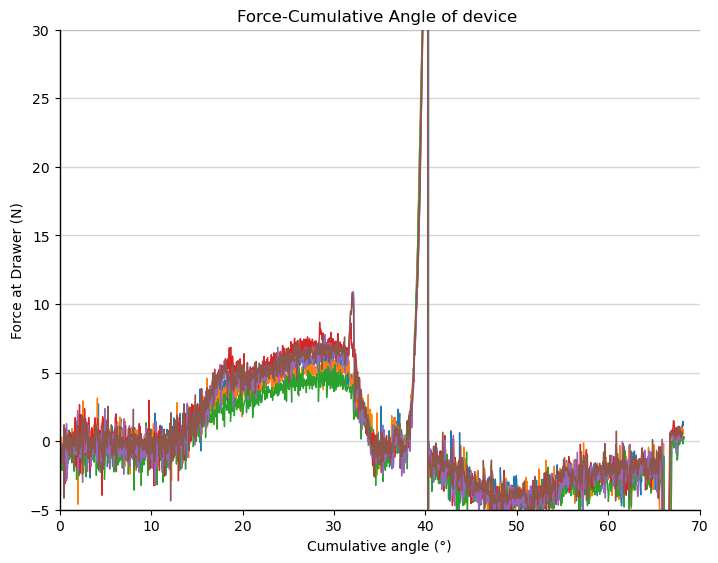

In [5]:
if __name__ == '__main__':
    # input data from .csv
    folder = input('Input .csv data folder directory: ')
    folder = fr'{folder}'
    file = input('Input .csv data filename (include \".csv\"):')
    file = fr'{file}'
    
    device = input('Device name: ')

    # Set which data points to plot
    to_plot = [1, -1]

    # Define rig geometry i.e. initialise Rig class
    rig = Rig()

    # Run main function
    main()
